# NLP With Hotel Review Part 2
#### Jonah Melhado

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading in data
df_train = pd.read_csv('data/train_dataframe.csv')
df_test = pd.read_csv('data/test_dataframe.csv')

In [3]:
# Checking data
df_train.shape

(13651, 2587)

In [4]:
# Test is ~20% of data 
df_test.shape

(3413, 2587)

In [5]:
# Making column names all lowercase
df_train.columns = df_train.columns.str.lower()
df_test.columns = df_test.columns.str.lower()

In [6]:
# Splitting into dependent and independent variables
X_train = df_train.drop(columns=['reviewer_score'])
y_train = df_train['reviewer_score']

X_test = df_test.drop(columns=['reviewer_score'])
y_test = df_test['reviewer_score']

First, we will drop all of the columns that are of no interest, i.e. those which are not words from positive/negative reviews. 

In [7]:
# Dropping unnecessary columns from independent variables
# Loop through columns and keep those that start with 'p_' or 'n_'

cols = []

for col in X_train.columns:
    if col[:2] == 'p_':
        cols.append(col)
    elif col[:2] == 'n_':
        cols.append(col)

In [8]:
# Keeping only useful columns
X_train = X_train[cols]
X_test = X_test[cols]

In [9]:
X_train.shape

(13651, 2177)

##### Q1.1 Fit a logistic regression model to this data with the solver set to `lbfgs`

*Note: I have chosen not to scale the data as the nature of the data set ensures that all of the data used will have similar values*

In [10]:
from sklearn.linear_model import LogisticRegression

# Instantiate
lr_model = LogisticRegression(solver='lbfgs')

# Fit
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [11]:
# Scoring
lr_model.score(X_test, y_test)

0.778493993554058

##### Q1.2 What are the 20 words most predictive of a good review (from the positive review column)? What are the 20 words most predictive with a bad review (from the negative review column)? Use the regression coefficients to answer this question

In [12]:
# Creating dataframe with coefficients and words only for easy sorting
# Create dataframe with the words as the columns and a single row of coefficient values
pred_words = pd.DataFrame(lr_model.coef_, columns=cols)

# Transpose dataframe and reset index so that we have two columns 'word' and 'coefficient'
pred_words = pred_words.T
pred_words.reset_index(inplace=True)
pred_words.columns = ['word', 'coefficient']

# Check
pred_words.head()

,word,coefficient
0,n_00,-0.815615
1,n_10,-0.095358
2,n_100,0.316293
3,n_11,-0.198117
4,n_11am,-0.334374


In [13]:
# Create separate dataframes for positive and negative words
neg_words = pred_words.loc[pred_words['word'].str[0] == 'n']
pos_words = pred_words.loc[pred_words['word'].str[0] == 'p']

In [14]:
# Check top 20 for negative reviews
neg_words.reindex(neg_words['coefficient'].abs().sort_values(ascending=False).index).head(20)

,word,coefficient
1072,n_staff,-3.158429
344,n_dirty,-2.772920
957,n_room,-2.687071
313,n_dated,-2.473692
778,n_old,-2.324261
1081,n_star,-2.293775
1153,n_tired,-2.147098
961,n_rude,-2.093681
1152,n_tiny,-2.087876
326,n_deluxe,-2.069257


In [15]:
# Check top 20 for positive reviews
pos_words.reindex(pos_words['coefficient'].abs().sort_values(ascending=False).index).head(20)

,word,coefficient
1310,p_amazing,2.448103
2113,p_upgraded,2.325486
1569,p_fantastic,2.250901
1563,p_fabulous,2.243356
1899,p_professional,2.030729
1843,p_outstanding,1.969803
2019,p_spotlessly,1.831495
1759,p_loved,1.818491
1546,p_excellent,1.812920
1883,p_poor,-1.782794


##### Q1.3 Reduce the dimensionality of the dataset using PCA, what is the relationship between the number of dimensions and run-time for a logistic regression?

In [16]:
from sklearn.decomposition import PCA
import time

In [17]:
# Arrays for times and number of dimensions
n_dims = np.arange(70, 151)
runtime = []

# Create loop
for dim in n_dims:
    
    # Instantiate and fit PCA
    lr_PCA = PCA(n_components=dim)
    lr_PCA.fit(X_train)
    
    # Transform
    X_train_reduced = lr_PCA.transform(X_train)
    
    # Start time
    start = time.perf_counter()
    
    # Perform logistic regression
    lr = LogisticRegression(solver='lbfgs')
    lr.fit(X_train_reduced, y_train)
    
    # End time
    end = time.perf_counter()
    
    # Store time taken in seconds
    runtime.append(end - start)

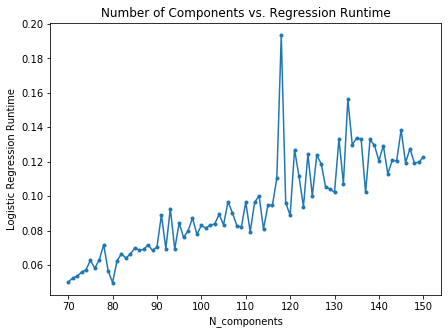

In [18]:
# Plotting times vs dimensions

plt.figure(figsize=(7,5))
plt.plot(n_dims, runtime, marker = '.')
plt.xlabel('N_components')
plt.ylabel('Logistic Regression Runtime')
plt.title('Number of Components vs. Regression Runtime')
plt.show()

Above, as expected, we can see that there is a positive relationship between the number of components and the runtime of the regression. It seems that although the regression runtime increases, the truly computationally intensive step is the principal component analysis and transformation of the dataset. 

##### Q1.4 List one advantage and one disadvantage of dimensionality reduction

Advantage: 

Having more features does not necessarily improve our models. If our model is working with an excess of features we can run the risk of our model fitting to noise created by extraneous data which could impact their ability to generalize and cause overfitting. Additionally, forgoing dimensionality reduction can be computationally expensive when there are many features in a dataset.

Disadvantage:

There are cases in which important variance information is not necessarily contained in individual features, but spread out across the dataset. In such cases reducing the dimensionality could lead to innaccuracy and cause our model to underperform when tested.   

##### Q2.1 Fit a KNN model to this data. What is the accuracy score on the test set?

In [19]:
from sklearn.neighbors import KNeighborsClassifier

In [20]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train)

X_train_s = ss.transform(X_train)
X_test_s = ss.transform(X_test)

In [21]:
# Instantiating model using the square root of the number of rows as k-value
knn_model = KNeighborsClassifier(n_neighbors=int(np.sqrt(X_train.shape[0])))

# Fitting model
knn_model.fit(X_train_s, y_train)

# Scoring model
# Checking train accuracy also out of curiosity
print(f'Train set accuracy: {knn_model.score(X_train_s, y_train)}')
print(f'Test set accuracy: {knn_model.score(X_test_s, y_test)}')

Train set accuracy: 0.5811295875760017
Test set accuracy: 0.5813067682390859


##### Q2.2 KNN is a computationally expensive model. Reduce the number of observations (data points) in the dataset. What is the relationship between the number of observations and the run-time for KNN?

We must take the sample from the original dataframe so we avoid associating the variables incorrectly.

In [23]:
# Setting up loop and timer
runtime = []

# Just making sure the lowest number of observations is still slightly greater than that of the test set
n_obs = np.arange(4000, 6000, 100)

for obs in n_obs:
    # Removing a portion of observations
    df_train_reduced = df_train.sample(n=obs)
    # Recall above using `cols` to use only columns of words
    X_train_reduced = df_train_reduced[cols]
    y_train_reduced = df_train_reduced['reviewer_score']
    
    # Start time
    start = time.perf_counter()
    
    # Instantiating model
    knn_model = KNeighborsClassifier(n_neighbors=int(np.sqrt(X_train_reduced.shape[0])))
    
    # Fitting model to reduced dataset
    knn_model.fit(X_train_reduced, y_train_reduced)
    
    # End time
    end = time.perf_counter()
    
    # Logging times
    runtime.append(end - start)

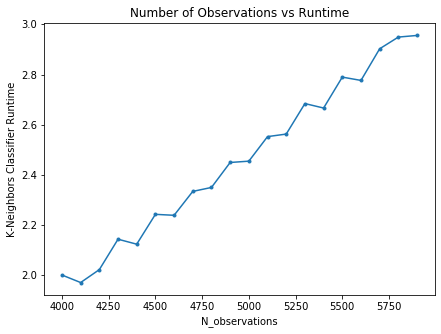

In [24]:
# Plotting runtime vs number of observations

plt.figure(figsize=(7,5))
plt.plot(n_obs, runtime, marker='.')
plt.xlabel('N_observations')
plt.ylabel('K-Neighbors Classifier Runtime')
plt.title('Number of Observations vs Runtime')
plt.show()

Runtime increases in an almost perfectly linear fashion as the number of observations increases.

##### Q2.3 List one advantage and one disadvantage of reducing the number of observations

Advantage:

The more data that is present, the more strain it will put on computing power. Reducing the number of observations can reduce the workload of analysis and allow models to fit much faster.

Disadvantage:

While reducing observations can allow us to fit models at a faster pace (and therefore make optimization quicker and easier) we are also losing potentially crucial data. 

##### Q2.4 Use the dataset to find an optimal value for K in the KNN algorithm. You will need to split your dataset into train and validation sets.

In [25]:
from sklearn.model_selection import train_test_split

# Splitting data into train and validation sets
X_train_, X_validation, y_train_, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=7)

In [27]:
# Find optimal K value
k_values = np.arange(4,51)

train_score = []
validation_score = []

knn_model = KNeighborsClassifier(n_neighbors=4).fit(X_train_, y_train_)

for k in k_values:
    
    # Instantiating
    knn_model = KNeighborsClassifier(n_neighbors=k)
    
    # Fitting
    knn_model.fit(X_train_, y_train_)
    
    # keeping track of how many models have been run
    print(k)
    
    # Scoring
    train_score.append(knn_model.score(X_train_, y_train_))
    validation_score.append(knn_model.score(X_validation, y_validation))
    
    print('...scored...')


4
...scored...
5
...scored...
6
...scored...
7
...scored...
8
...scored...
9
...scored...
10
...scored...
11
...scored...
12
...scored...
13
...scored...
14
...scored...
15
...scored...
16
...scored...
17
...scored...
18
...scored...
19
...scored...
20
...scored...
21
...scored...
22
...scored...
23
...scored...
24
...scored...
25
...scored...
26
...scored...
27
...scored...
28
...scored...
29
...scored...
30
...scored...
31
...scored...
32
...scored...
33
...scored...
34
...scored...
35
...scored...
36
...scored...
37
...scored...
38
...scored...
39
...scored...
40
...scored...
41
...scored...
42
...scored...
43
...scored...
44
...scored...
45
...scored...
46
...scored...
47
...scored...
48
...scored...
49
...scored...
50
...scored...


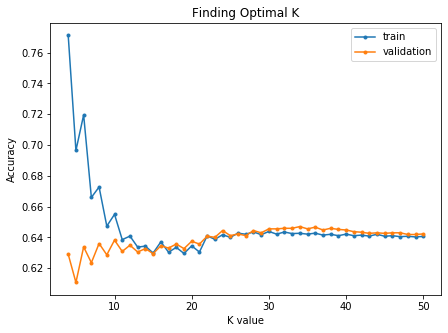

In [28]:
# plotting K values vs accuracy
plt.figure(figsize=(7,5))
plt.plot(k_values, train_score, label='train', marker='.')
plt.plot(k_values, validation_score, label='validation', marker='.')
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.title('Finding Optimal K')
plt.legend()
plt.show()

As we can see above, the K nearest neighbors model is overfitted to the training set until around `k = 10`.

##### Q2.5 What is the issue with splitting the data into train and validation sets **after** performing vectorization?

If we split the data after vectorization there will be some words present in the train set that are not present in the validation set and vice-versa. 

##### Q3.1 Fit a decision tree model to this data. What is the accuracy score on the test set?

In [29]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
# Instantiating
dt_model = DecisionTreeClassifier(max_depth=15)

# Fitting
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [31]:
# Scoring
dt_model.score(X_test, y_test)

0.7257544682097861

##### Q3.2 Use the data set (or a subsample) to find an optimal value for the maximum depth of the decision tree. You will need to split your data set into train and validation

In [32]:
# Using validation and train sets created above for KNN

# Creating lists to store accuracy values and values for max_depth

depths = np.arange(1, 21)
train_acc = []
validation_acc = []

# Looping through models to create lists and plot scores
for depth in depths:
    dt_model = DecisionTreeClassifier(max_depth=depth)
    
    dt_model.fit(X_train_,y_train_)
    
    train_acc.append(dt_model.score(X_train_, y_train_))
    validation_acc.append(dt_model.score(X_validation, y_validation))

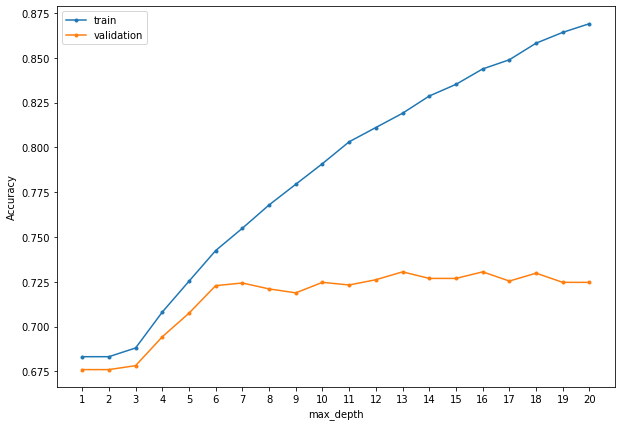

In [33]:
# Visualizing accuracies to determine optimal max_depth

plt.figure(figsize=(10,7))
plt.plot(depths, train_acc, label='train', marker='.')
plt.plot(depths, validation_acc, label='validation', marker='.')
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1,21))
plt.show()

In [34]:
dt_model = DecisionTreeClassifier(max_depth=6).fit(X_train,y_train)
dt_model.score(X_test, y_test)

0.7245824787576912

Based on the plot above, the optimal value seems to be `max_depth = 6` as after the plot starts to diverge indicating the model tending towards overfitting on the training data

##### Q3.3 Provide two advantages of decision trees over KNN. Provide two weaknesses of decision trees (classification or regression trees)

Advantages:
- They require less processing power than KNN
- The data does not require preprocessing

Weaknesses:
- Decision trees tend to overfit on the training data making it difficult to generalize the modeltyty
- The tree can become extremely complex when trained on complicated data sets

##### Q4 What is the purpose of the validation set, i.e. how is it different from the test set?

A validation set is useful for tuning a model's hyperparameeters such as the k-value for a K-neighbors classifier or the regularization penalty in a logistic regression. A validation set allows us to perform an unbiased test of the model's performance with different hyperparameters. This allows us to see how well our model will generalize and make it more 'fair' as we can avoid overfitting to the test data, thus increasing the credibility of the model's predictions on the test data. 

##### Q5.1 Perform a 5-fold cross validation to optimize the hyperparameters of your model

In [35]:
from sklearn.model_selection import cross_val_score

In [57]:
# C-values for 1e-09 to 1e9
c_values = [10**i for i in range(-8,9)]
cross_val = []

# Using a logistic regression model
for c in c_values:
    lr_model = LogisticRegression(solver='lbfgs', random_state=7, C=c)
    lr_model.fit(X_train, y_train)
    cross_val.append(np.mean(cross_val_score(lr_model, X_train, y_train, cv=5)))
    

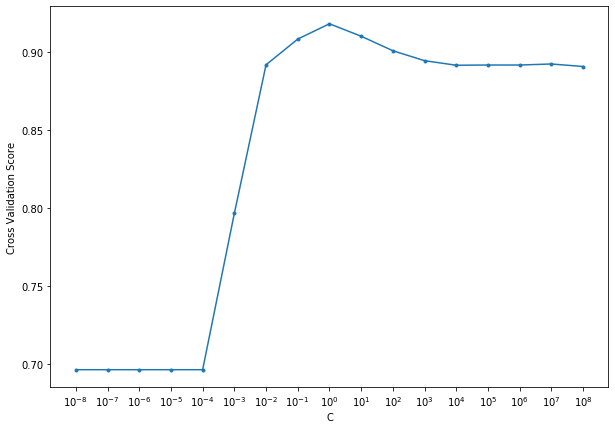

In [58]:
plt.figure(figsize=(10,7))
plt.plot(c_values, cross_val, marker='.')
plt.xlabel('C')
plt.ylabel('Cross Validation Score')
plt.xscale('log')
plt.xticks(c_values)
plt.show()

`C = 1.0` is the optimal value

In [59]:
# Checking test accuracy for C = 1.0
lr_model = LogisticRegression(solver='lbfgs', C=1e-4, random_state=7)
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.7588631702314679

##### Q5.2 What does your confusion matrix look like for your best model on the test set?

In [41]:
from sklearn.metrics import confusion_matrix

lr_model = LogisticRegression(solver='lbfgs', C=1.0, random_state=7) 

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

c_matrix = confusion_matrix(y_test, y_pred)
print(c_matrix)

[[ 989  440]
 [ 316 1668]]


In [42]:
matrix = pd.DataFrame(c_matrix, index=['True Positive', 'True Negative'], columns=['False Positive', 'False Negative'])
matrix

,False Positive,False Negative
True Positive,989,440
True Negative,316,1668


The confusion matrix looks quite good, with our model identifying 989 of the positive values correctly and 1668 of the negative values correctly.

#### Q6.0 Create one new feature of your choice

##### Q6.1 Explain your new feature and why you consider it will improve accuracy

Using the average score that reviewers give to create a new column which is 1 when the average is 9 or above and 0 when their average is below 9. It would follow that this would improve accuracy because if a reviewer is more generous (more likely to give higher scores) then their reviews are more likely to be positive and their score on the hotel in question will also be 9 or more.

In [43]:
# Creating new column to indicate reviewer generosity
df_train['generous_reviewer'] = 1
# Placing 0's where average score is less than 9
df_train.loc[df_train['average_score'].round() < 9] = 0

# Same as above for test set
df_test['generous_reviewer'] = 1
df_test.loc[df_train['average_score'].round() < 9] = 0

In [44]:
cols.append('generous_reviewer')

# Re-creating the independent variable set to include the new column
X_train = df_train[cols]
X_test = df_test[cols]

In [45]:
# Checking to see if the column is included
print(X_train.columns)

Index(['n_00', 'n_10', 'n_100', 'n_11', 'n_11am', 'n_11pm', 'n_12', 'n_13',
       'n_15', 'n_16',
       ...
       'p_working', 'p_world', 'p_worth', 'p_wouldn', 'p_year', 'p_years',
       'p_yes', 'p_young', 'p_yummy', 'generous_reviewer'],
      dtype='object', length=2178)


##### Q6.2 Run the model from question 5 again. You will have to re-optimize your hyperparameters. Has the accuracy score of your best model improved on the test set after adding the new feature you created?

In [46]:
# C-values for 1e-09 to 1e9
c_values = [10**i for i in range(-8,9)]
cross_val = []

# Re-optimizing
for c in c_values:
    lr_model = LogisticRegression(solver='lbfgs', random_state=7, C=c)
    lr_model.fit(X_train, y_train)
    cross_val.append(np.mean(cross_val_score(lr_model, X_train, y_train, cv=5)))
    

C:\Users\TEMP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\TEMP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regre

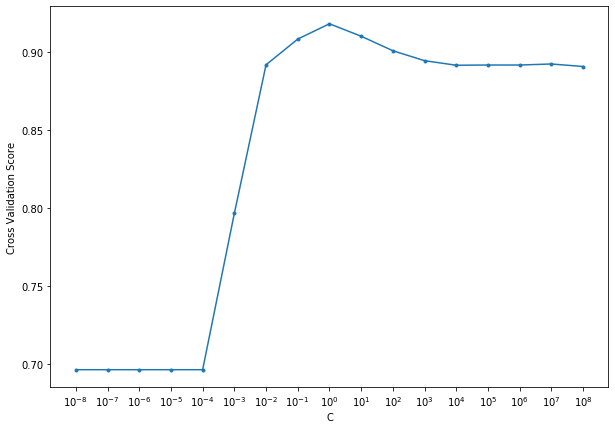

In [47]:
# Plotting cross val scores
plt.figure(figsize=(10,7))
plt.plot(c_values, cross_val, marker='.')
plt.xlabel('C')
plt.ylabel('Cross Validation Score')
plt.xscale('log')
plt.xticks(c_values)
plt.show()

In [49]:
# C=1.0 is once more the optimal value
lr_model = LogisticRegression(solver='lbfgs', random_state=7, C=1.0)
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.8977439203047173

As shown above the accuracy has increased by more than 0.1 on the test set which indicates that the new feature has had a significant impact on our ability to predict reviewer score.